In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'additional_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [7]:
space ={'max_depth': hp.randint('x_max_depth',  10),
        'min_child_weight': hp.randint ('x_min_child', 20),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

# MEGNO

In [8]:
features = ['MEGNO']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.5                                                 
ERROR                                               
0.0                                                 
SCORE:                                                        
0.5                                                           
ERROR                                                         
0.0                                                           
SCORE:                                                        
0.8612528000000002                                            
ERROR                                                         
0.0016079927252848013                                         
SCORE:                                                                        
0.5                                                                           
ERROR                                                                         
0.0                                            

0.86132168                                                                     
ERROR                                                                          
0.0015764672064262966                                                          
SCORE:                                                                         
0.8612801000000001                                                             
ERROR                                                                          
0.0016114915560946556                                                          
SCORE:                                                                         
0.86119194                                                                     
ERROR                                                                          
0.001576937453495781                                                           
SCORE:                                                                         
0.82033804                              

In [10]:
best

{'x_learning_rate': 0.15230704268614442,
 'x_max_depth': 6,
 'x_min_child': 4,
 'x_subsample': 0.8371869407199811}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [11]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=50)

[0]	train-auc:0.86245+0.00058	test-auc:0.85980+0.00180
[1]	train-auc:0.86341+0.00063	test-auc:0.86078+0.00171
[2]	train-auc:0.86400+0.00043	test-auc:0.86131+0.00158
[3]	train-auc:0.86436+0.00044	test-auc:0.86146+0.00157
[4]	train-auc:0.86458+0.00045	test-auc:0.86159+0.00151
[5]	train-auc:0.86473+0.00046	test-auc:0.86179+0.00144
[6]	train-auc:0.86493+0.00049	test-auc:0.86181+0.00144
[7]	train-auc:0.86515+0.00034	test-auc:0.86182+0.00149
[8]	train-auc:0.86541+0.00041	test-auc:0.86191+0.00146
[9]	train-auc:0.86557+0.00041	test-auc:0.86201+0.00152
[10]	train-auc:0.86572+0.00044	test-auc:0.86197+0.00148
[11]	train-auc:0.86599+0.00044	test-auc:0.86210+0.00151
[12]	train-auc:0.86615+0.00044	test-auc:0.86221+0.00146
[13]	train-auc:0.86627+0.00045	test-auc:0.86223+0.00147
[14]	train-auc:0.86644+0.00047	test-auc:0.86222+0.00152
[15]	train-auc:0.86652+0.00047	test-auc:0.86216+0.00154
[16]	train-auc:0.86662+0.00048	test-auc:0.86220+0.00160
[17]	train-auc:0.86675+0.00045	test-auc:0.86222+0.00161
[1

Text(0, 0.5, 'CV AUC score')

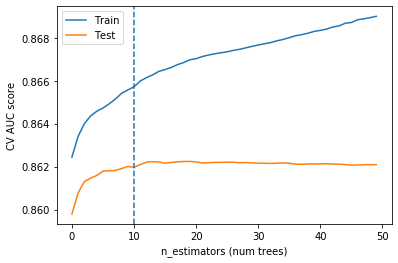

In [13]:
n_estimators = 10
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [14]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15230704268614442, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8371869407199811,
              tree_method=None, validate_parameters=False, verbosity=None)

In [15]:
model.save_model(datapath+'../spock/models/megno.json')

In [16]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/megno.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.866)')

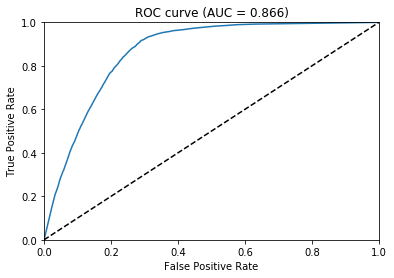

In [17]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [24]:
for i in range(0,len(tpr), 5):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.6124969720840454, TPR = 0.0, FPR = 0.0
Threshold 0.5962888598442078, TPR = 0.19939577039274925, FPR = 0.03158559696778269
Threshold 0.5710986852645874, TPR = 0.27794561933534745, FPR = 0.04726353873542755
Threshold 0.559128999710083, TPR = 0.3183534743202417, FPR = 0.05800264170447367
Threshold 0.541252613067627, TPR = 0.4265483383685801, FPR = 0.08304140584620685
Threshold 0.5267432928085327, TPR = 0.449773413897281, FPR = 0.09010509389536553
Threshold 0.5241249799728394, TPR = 0.5058534743202417, FPR = 0.10503646700740826
Threshold 0.503821849822998, TPR = 0.5251132930513596, FPR = 0.11060701774536266
Threshold 0.49678704142570496, TPR = 0.5929003021148036, FPR = 0.13214265204157813
Threshold 0.4931870102882385, TPR = 0.5953549848942599, FPR = 0.13340607592028944
Threshold 0.48184260725975037, TPR = 0.6000755287009063, FPR = 0.13495664158961695
Threshold 0.47422555088996887, TPR = 0.6263217522658611, FPR = 0.1443748923218285
Threshold 0.46474653482437134, TPR = 0.66824018

# AMD

In [26]:
features = ['AMDfracnear', 'AMDfracfar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [27]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.5                                                 
ERROR                                               
0.0                                                 
SCORE:                                                        
0.5                                                           
ERROR                                                         
0.0                                                           
SCORE:                                                        
0.74246314                                                    
ERROR                                                         
0.0018824653405077087                                         
SCORE:                                                               
0.5                                                                  
ERROR                                                                
0.0                                                                  
SCOR

SCORE:                                                                
0.7427604000000001                                                    
ERROR                                                                 
0.0016885006564100907                                                 
SCORE:                                                                        
0.7425808999999999                                                            
ERROR                                                                         
0.0014733791202212996                                                         
SCORE:                                                                        
0.74266122                                                                    
ERROR                                                                         
0.0017886505609893302                                                         
SCORE:                                                                        
0.742

In [28]:
best

{'x_learning_rate': 0.19593327021614335,
 'x_max_depth': 6,
 'x_min_child': 5,
 'x_subsample': 0.8847005492064374}

In [29]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=50)

[0]	train-auc:0.74581+0.00032	test-auc:0.74041+0.00202
[1]	train-auc:0.74787+0.00050	test-auc:0.74186+0.00162
[2]	train-auc:0.74877+0.00061	test-auc:0.74216+0.00180
[3]	train-auc:0.74951+0.00053	test-auc:0.74255+0.00166
[4]	train-auc:0.75015+0.00055	test-auc:0.74289+0.00161
[5]	train-auc:0.75083+0.00050	test-auc:0.74325+0.00162
[6]	train-auc:0.75155+0.00047	test-auc:0.74357+0.00155
[7]	train-auc:0.75202+0.00059	test-auc:0.74371+0.00146
[8]	train-auc:0.75238+0.00060	test-auc:0.74364+0.00170
[9]	train-auc:0.75269+0.00055	test-auc:0.74357+0.00184
[10]	train-auc:0.75304+0.00051	test-auc:0.74369+0.00188
[11]	train-auc:0.75328+0.00052	test-auc:0.74368+0.00192
[12]	train-auc:0.75372+0.00067	test-auc:0.74376+0.00184
[13]	train-auc:0.75402+0.00067	test-auc:0.74376+0.00190
[14]	train-auc:0.75429+0.00067	test-auc:0.74396+0.00195
[15]	train-auc:0.75462+0.00068	test-auc:0.74386+0.00184
[16]	train-auc:0.75496+0.00073	test-auc:0.74392+0.00168
[17]	train-auc:0.75533+0.00077	test-auc:0.74399+0.00158
[1

Text(0, 0.5, 'CV AUC score')

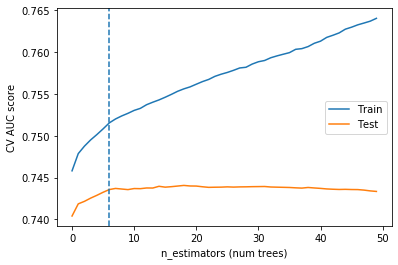

In [31]:
n_estimators = 6
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [32]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.19593327021614335, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8847005492064374,
              tree_method=None, validate_parameters=False, verbosity=None)

In [33]:
model.save_model(datapath+'../spock/models/AMD.json')

In [34]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/AMD.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.737)')

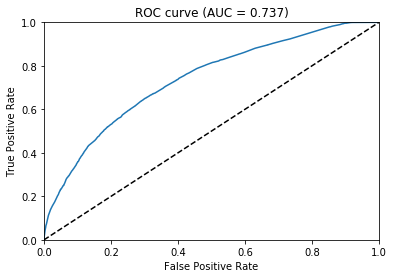

In [35]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# Hill

In [36]:
features = ['betanear', 'betafar']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [37]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.5                                                 
ERROR                                               
0.0                                                 
SCORE:                                                        
0.5                                                           
ERROR                                                         
0.0                                                           
SCORE:                                                        
0.72115924                                                    
ERROR                                                         
0.0008330271555922819                                         
SCORE:                                                               
0.5                                                                  
ERROR                                                                
0.0                                                                  
SCOR

0.0008770154764299766                                                 
SCORE:                                                                
0.7212758399999999                                                    
ERROR                                                                 
0.0008108366953093547                                                 
SCORE:                                                                
0.7210861800000001                                                    
ERROR                                                                 
0.0005725149122170598                                                 
SCORE:                                                                
0.72109016                                                            
ERROR                                                                 
0.000879679060593273                                                  
SCORE:                                                                
0.7173

In [38]:
best

{'x_learning_rate': 0.19849685217702318,
 'x_max_depth': 6,
 'x_min_child': 4,
 'x_subsample': 0.8001495134481562}

In [43]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=50)

[0]	train-auc:0.72514+0.00062	test-auc:0.71680+0.00182
[1]	train-auc:0.72853+0.00052	test-auc:0.71992+0.00052
[2]	train-auc:0.72994+0.00040	test-auc:0.72115+0.00077
[3]	train-auc:0.73103+0.00019	test-auc:0.72169+0.00089
[4]	train-auc:0.73185+0.00026	test-auc:0.72200+0.00081
[5]	train-auc:0.73251+0.00015	test-auc:0.72236+0.00066
[6]	train-auc:0.73300+0.00030	test-auc:0.72268+0.00063
[7]	train-auc:0.73343+0.00023	test-auc:0.72294+0.00067
[8]	train-auc:0.73384+0.00024	test-auc:0.72305+0.00068
[9]	train-auc:0.73432+0.00033	test-auc:0.72324+0.00067
[10]	train-auc:0.73468+0.00033	test-auc:0.72319+0.00077
[11]	train-auc:0.73501+0.00030	test-auc:0.72321+0.00082
[12]	train-auc:0.73531+0.00028	test-auc:0.72326+0.00083
[13]	train-auc:0.73569+0.00035	test-auc:0.72328+0.00076
[14]	train-auc:0.73607+0.00032	test-auc:0.72327+0.00082
[15]	train-auc:0.73636+0.00034	test-auc:0.72332+0.00091
[16]	train-auc:0.73671+0.00026	test-auc:0.72337+0.00088
[17]	train-auc:0.73711+0.00035	test-auc:0.72335+0.00088
[1

Text(0, 0.5, 'CV AUC score')

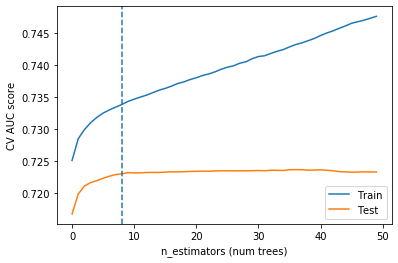

In [45]:
n_estimators = 8
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [46]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.19849685217702318, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=8, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8001495134481562,
              tree_method=None, validate_parameters=False, verbosity=None)

In [47]:
model.save_model(datapath+'../spock/models/hill.json')

In [48]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/hill.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.725)')

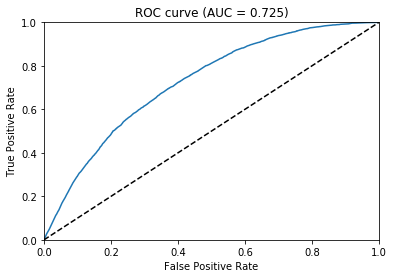

In [49]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# N-body

In [50]:
datapath = '../training_data/'
dset = 'resonant/'
featurefolder = 'shadowtimes/'
trainingdatafolder = datapath+dset+featurefolder
features=None

In [59]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)
dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [60]:
shadowstable = trainX['shadow_instability_time'] > 8.99e8

2% had stability in shadow integration disagree with nominal integration

In [61]:
(trainY != shadowstable).sum()/trainY.shape[0]

0.016084285619922055

In [62]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.5                                                 
ERROR                                               
0.0                                                 
SCORE:                                                        
0.5                                                           
ERROR                                                         
0.0                                                           
SCORE:                                                        
0.9899057600000001                                            
ERROR                                                         
0.0009376993960080948                                         
SCORE:                                                                         
0.5                                                                            
ERROR                                                                          
0.0                                         

SCORE:                                                                          
0.98985794                                                                      
ERROR                                                                           
0.0009625295810771201                                                           
SCORE:                                                                          
0.98991662                                                                      
ERROR                                                                           
0.0009513533163838133                                                           
SCORE:                                                                          
0.98992822                                                                      
ERROR                                                                           
0.0009353138350319997                                                           
SCORE:                      

In [64]:
best

{'x_learning_rate': 0.19797937959730308,
 'x_max_depth': 3,
 'x_min_child': 5,
 'x_subsample': 0.945591939597905}

In [63]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=50)

[0]	train-auc:0.98973+0.00022	test-auc:0.98960+0.00099
[1]	train-auc:0.98982+0.00021	test-auc:0.98974+0.00094
[2]	train-auc:0.98988+0.00024	test-auc:0.98976+0.00093
[3]	train-auc:0.98989+0.00024	test-auc:0.98976+0.00093
[4]	train-auc:0.99008+0.00030	test-auc:0.99003+0.00090
[5]	train-auc:0.99027+0.00024	test-auc:0.99013+0.00089
[6]	train-auc:0.99028+0.00024	test-auc:0.99010+0.00087
[7]	train-auc:0.99040+0.00017	test-auc:0.99027+0.00073
[8]	train-auc:0.99040+0.00016	test-auc:0.99027+0.00073
[9]	train-auc:0.99040+0.00016	test-auc:0.99027+0.00073
[10]	train-auc:0.99041+0.00017	test-auc:0.99029+0.00071
[11]	train-auc:0.99041+0.00017	test-auc:0.99029+0.00071
[12]	train-auc:0.99042+0.00018	test-auc:0.99033+0.00069
[13]	train-auc:0.99042+0.00018	test-auc:0.99033+0.00069
[14]	train-auc:0.99047+0.00022	test-auc:0.99039+0.00065
[15]	train-auc:0.99047+0.00021	test-auc:0.99041+0.00069
[16]	train-auc:0.99052+0.00024	test-auc:0.99042+0.00068
[17]	train-auc:0.99057+0.00023	test-auc:0.99047+0.00062
[1

Text(0, 0.5, 'CV AUC score')

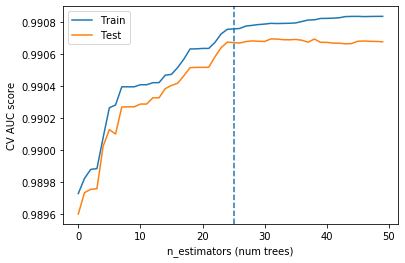

In [67]:
n_estimators = 25
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

In [69]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.19797937959730308, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.945591939597905,
              tree_method=None, validate_parameters=False, verbosity=None)

In [70]:
model.save_model(datapath+'../spock/models/nbody.json')

In [71]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/nbody.json')

Text(0.5, 1.0, 'ROC curve (AUC = 0.991)')

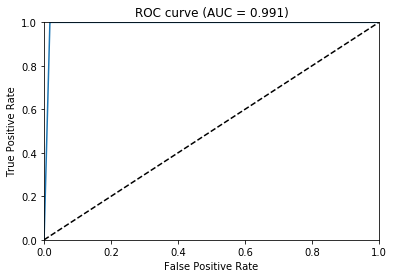

In [72]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))